In [188]:
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [189]:
# Load dataset, split into test and training data
train_ds, test_ds = tfds.load('fashion_mnist', split= ['train', 'test'], data_dir="data\\", as_supervised=True, shuffle_files=True)

In [190]:
def overview_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  #Look at shapes images and labels of dataset
  print("length train: ",len(train_ds))
  print("length train: ",len(test_ds))

  x = 0
  for i in train_ds_numpy:
    x += 1
    # print(i)
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

  x = 0
  for i in test_ds_numpy:
    x += 1
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

overview_data()

length train:  60000
length train:  10000
shape  (28, 28, 1)
max  255
min  0
2
shape  (28, 28, 1)
max  254
min  0
6
shape  (28, 28, 1)
max  255
min  0
1
shape  (28, 28, 1)
max  255
min  0
9
shape  (28, 28, 1)
max  255
min  0
5
shape  (28, 28, 1)
max  255
min  0
4


<Figure size 576x576 with 0 Axes>

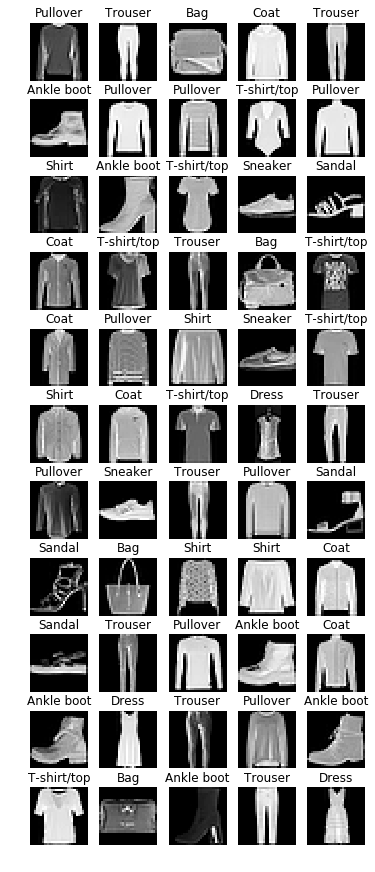

In [191]:
def tile_plot(train,imgs=55,greyscale=True,scale=False):
    # This function plots the images in a tiled fashion, for better visualization.
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 10
    fig, ax = plt.subplots(1,imgs)
    for i,j in enumerate(tfds.as_numpy(train)):
        img= j[0]
        
        label = {
        0 : 'T-shirt/top',
        1 : 'Trouser',
        2 : 'Pullover',
        3 : 'Dress',
        4 : 'Coat',
        5 : 'Sandal',
        6 : 'Shirt',
        7 : 'Sneaker',
        8 : 'Bag',
        9 : 'Ankle boot'
        }
        # if label is still just an integer
        if isinstance(j[1], np.int64):
            lbl = label[j[1]]
        else:
            indice = np.where(j[1] == 1)
            indice = indice[0]
            lbl = label[int(indice)]
        subax = fig.add_subplot(rows+1,columns+1,i+1)   
        subax.axis("off")
        subax.set_title(lbl)

        if greyscale: #Dealing with grayscale images requires a different approach, since imshow doesn't handle them as adroitly as RGB
            if scale: # This is to visualize our normalized images. Since this doesn't conform to the standard scale, we have to define our own
                plt.imshow(np.squeeze(img),vmin=-2, vmax= 2.5,cmap="gray")
            else:
                plt.imshow(tf.cast(np.squeeze(img),tf.uint8),cmap="gray")
        else:
            plt.imshow(tf.cast(img,tf.uint8)) #cast to uint because otherwise there's an error from matplotlib
        ax[i].axis("off")
        if i == (imgs-1): 
            # this is really awkward, but sadly prefetch_datasets are quite particular about indexing.
            # converting them to numpy first might be smarter in the future
            break
    plt.subplots_adjust(top=3)
    plt.show()

tile_plot(train_ds)

In [192]:
#Build input pipeline
train_ds = train_ds.map(lambda image, label: (tf.image.per_image_standardization(tf.cast(image, tf.float32)), tf.reshape(tf.one_hot(label, 10), (-1,))))
test_ds = test_ds.map(lambda image, label: (tf.image.per_image_standardization(tf.cast(image, tf.float32)), tf.reshape(tf.one_hot(label, 10), (-1,))))

prefetch_size = tf.data.experimental.AUTOTUNE

# batching, shuffle und prefetching
train_ds = train_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)
test_ds = test_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)

In [193]:
from IPython.display import clear_output

def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

In [194]:
class TransitionLayer(Layer):

    def __init__(self,growth_rate):
        super(TransitionLayer, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = growth_rate,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu
        
        self.pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=2)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()


    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        x = self.pool1(x)
        x = self.batch_norm_2(x,training=training)

        return x

In [195]:
class DenseNet(Model):

    def __init__(self,blocks,growth_rate):
        super(DenseNet, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = growth_rate*2,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (64, 32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        growth_rate = growth_rate*3 #2 times from first layer, then another one for after 1st block

        self.blocks=[]
        for i in range(0,blocks):
            self.blocks.append(DenseBlock())
            self.blocks.append(TransitionLayer(growth_rate))
            growth_rate += growth_rate


        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer_10 = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)


    def call(self,x,training):
        
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)

        for i in self.blocks:
            x = i(x,training=training)
            

        x = self.global_pooling_layer_8(x)
        x = self.output_layer_10(x)

        return x

In [196]:
class CNN_layer(Layer):
    
    def __init__(self):
        super(CNN_layer, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = 28*2,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
        self.activ_1 = tf.keras.activations.relu

    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        return x


In [197]:
class Encoder(Model):
    
    def __init__(self):
        super(Encoder, self).__init__()

        self.hidden = [
            CNN_layer(),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # 14
            CNN_layer(),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # 7
            CNN_layer(),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # 4
            CNN_layer(),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # 2
            CNN_layer(),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # 1
        ]

    def call(self,x,training):
        for i in self.layers:
            x = i(x,training=training)
            for i in x:
                print(i.shape)
                break
        return x


In [198]:
class Decoder(Model):
    
    def __init__(self):
        super(Decoder, self).__init__()

        #upscale the cnn

In [199]:
class Auto_encoder(Model):
    
    def __init__(self):
        super(Auto_encoder, self).__init__()

In [200]:
class VAE(Model):
    
    def __init__(self):
        super(VAE, self).__init__()

In [201]:
def train_step(model, data, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  
  with tf.GradientTape() as tape:
    prediction = model(data, training = True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss 


def test_step(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (data, target) in test_data:
    prediction = model(data, training = False)
    
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [202]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = tf.optimizers.schedules.ExponentialDecay(0.001, 5000, 0.97, staircase=True)
running_average_factor = 0.95

# Initialize the model.
model = Encoder()


# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test_step(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test_step(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)
print(model.summary())

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (data,target) in train_ds:
        train_loss = train_step(model, data, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test_step(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    end = time.perf_counter()
    plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))

(28, 28, 56)
(14, 14, 56)
(14, 14, 56)
(7, 7, 56)
(7, 7, 56)
(4, 4, 56)
(4, 4, 56)
(2, 2, 56)
(2, 2, 56)
(1, 1, 56)


ValueError: Shapes (64, 10) and (64, 1, 1, 56) are incompatible

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()